## The problematic eigenvalues for BDF3

Define
$$
\mu(x,\Delta x)=\left\{\left|\frac {\left|\xi(\Delta x \lambda)\right|-1}{\Delta x}\right|:\lambda\in \sigma\left(A+xB\right)\right\}.
$$

The following plots show for each value of $x\in 13,12,\cdots,-9,-10$, how the (normalized) number of problematic eigenvalues (outside of the absolute stability region of BDF3) change with respect to $\Delta x$, where the number of Fourier modes is fixed at $8000$ and $\beta=2$ for all plots. Besides, for each value of $\Delta x$, for those problematic eigenvalues, we also compute the mean of $\mu(x,\Delta x)$.

In [1]:
using TracyWidomBeta,LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions
using RandomMatrices,Plots,LaTeXStrings,TypedTables,StatsBase,FFTW

In [2]:
ρ = (α,z) -> (z.^(length(α)-1:-1:0))'*α
σ = (β,z) -> (z.^(length(β)-1:-1:0))'*β
R = (α,β,z) -> ρ(α,z)/σ(β,z)
function find_roots(c) # supposing that the leading order coefficient is 1
    # c contains the remaining coefficients
    r = length(c)
    A = zeros(Complex{Float64},r,r)
    A[1,:] = -c
    A[2:end,1:end-1] = A[2:end,1:end-1] + I # add identity matrix to lower-left block
    return eigvals(A)
end
function compute_roots(α,β,z)
    r = length(α)-1
    c = α-z*β
    if α[1]-z*β[1] ≈ 0.
        λ = find_roots(c[3:end]/c[2])
    else
        λ = find_roots(c[2:end]/c[1]) # let's suppose that first and second coefficients don't vanish simultaneously
    end
    return λ
end
function check_condition(λ)
    if maximum(abs.(λ)) > 1
        return 0
    else
        for i = 1:length(λ)
            if abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
                return 0
            end
        end
    end
    return 1
end
function check_condition2(λ)
    ξ_rest=zeros(ComplexF64,0)
    for i=1:length(λ)
        if abs(λ[i])>1
            append!(ξ_rest,λ[i])
        elseif abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
            append!(ξ_rest,λ[i])
        end
    end
    return ξ_rest
end
function root_condition(α,β,z)
    return compute_roots(α,β,z) |> check_condition
end

root_condition (generic function with 1 method)

Construct the matrices.

In [3]:
β=2;
M_f=1000;#just some random value
mgrid=(n,L) -> L*(1:n)/n;
θ=mgrid(M_f,pi);
M_s=8000;
h=(1/M_f)*pi;
method="spectral";
l=10;
(A,B)=TracyWidomBeta.matrix_gen(β;method,M_f,M_s,h,θ,l);

For $x=-10$, we have

In [4]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm10=zeros(1,length(Delta_x));r_rightm10=zeros(1,length(Delta_x));
v_leftm10=zeros(1,length(Delta_x));v_rightm10=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm10[j]=length(z_left)/M_s;
    r_rightm10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm10[j]=0
    end
    if length(ξ_right)==0
        v_rightm10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm10[j]=mean(μ_right)
    end
end

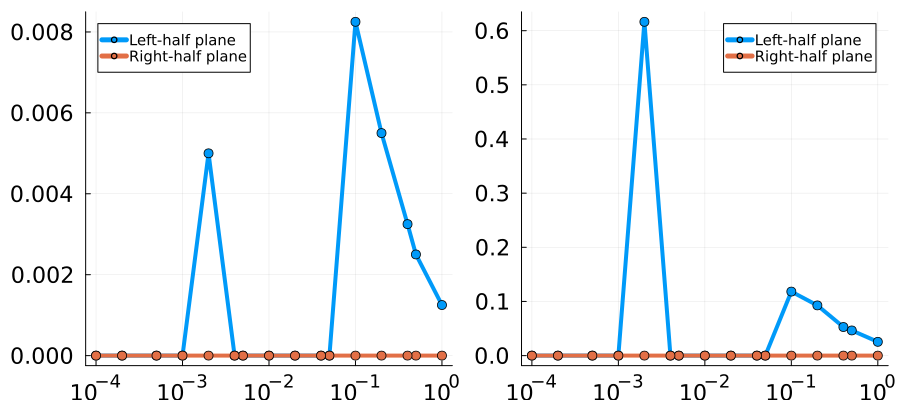

In [7]:
p_m10r=Plots.plot();
p_m10r=plot!(Delta_x.*(-1),vec(r_leftm10),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10r=plot!(Delta_x.*(-1),vec(r_rightm10),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=Plots.plot();
p_m10v=plot!(Delta_x.*(-1),vec(v_leftm10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=plot!(Delta_x.*(-1),vec(v_rightm10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m10r,p_m10v,size=(900,400))

In [6]:
t_m10=Table(Δx=Delta_x,ratio_left=vec(r_leftm10),mean_left=vec(v_leftm10),ratio_right=vec(r_rightm10),mean_right=vec(v_rightm10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00125     0.0254106  0.0          0.0
 2  │ -0.5     0.0025      0.0464567  0.0          0.0
 3  │ -0.4     0.00325     0.0527673  0.0          0.0
 4  │ -0.2     0.0055      0.0927002  0.0          0.0
 5  │ -0.1     0.00825     0.118188   0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.0         0.0        0.0          0.0
 12 │ -0.002   0.005       0.616342   0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-9$, we have

In [8]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm9=zeros(1,length(Delta_x));r_rightm9=zeros(1,length(Delta_x));
v_leftm9=zeros(1,length(Delta_x));v_rightm9=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm9[j]=length(z_left)/M_s;
    r_rightm9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm9[j]=0
    end
    if length(ξ_right)==0
        v_rightm9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm9[j]=mean(μ_right)
    end
end

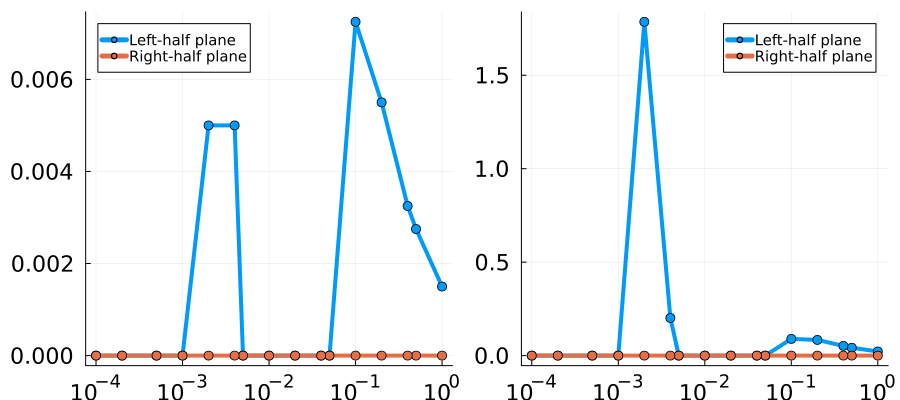

In [9]:
p_m9r=Plots.plot();
p_m9r=plot!(Delta_x.*(-1),vec(r_leftm9),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9r=plot!(Delta_x.*(-1),vec(r_rightm9),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=Plots.plot();
p_m9v=plot!(Delta_x.*(-1),vec(v_leftm9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=plot!(Delta_x.*(-1),vec(v_rightm9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m9r,p_m9v,size=(900,400))

In [10]:
t_m9=Table(Δx=Delta_x,ratio_left=vec(r_leftm9),mean_left=vec(v_leftm9),ratio_right=vec(r_rightm9),mean_right=vec(v_rightm9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0015      0.022148   0.0          0.0
 2  │ -0.5     0.00275     0.0420561  0.0          0.0
 3  │ -0.4     0.00325     0.0519798  0.0          0.0
 4  │ -0.2     0.0055      0.0838976  0.0          0.0
 5  │ -0.1     0.00725     0.0893959  0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.005       0.201468   0.0          0.0
 12 │ -0.002   0.005       1.7856     0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-8$, we have

In [11]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm8=zeros(1,length(Delta_x));r_rightm8=zeros(1,length(Delta_x));
v_leftm8=zeros(1,length(Delta_x));v_rightm8=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm8[j]=length(z_left)/M_s;
    r_rightm8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm8[j]=0
    end
    if length(ξ_right)==0
        v_rightm8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm8[j]=mean(μ_right)
    end
end

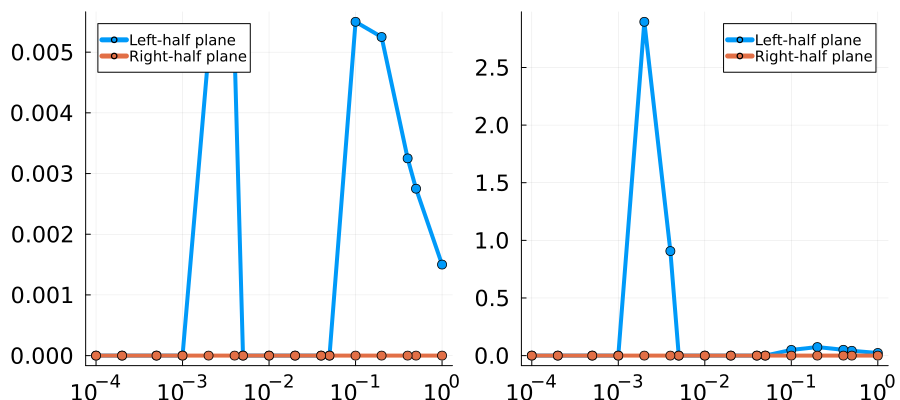

In [12]:
p_m8r=Plots.plot();
p_m8r=plot!(Delta_x.*(-1),vec(r_leftm8),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8r=plot!(Delta_x.*(-1),vec(r_rightm8),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=Plots.plot();
p_m8v=plot!(Delta_x.*(-1),vec(v_leftm8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=plot!(Delta_x.*(-1),vec(v_rightm8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m8r,p_m8v,size=(900,400))

In [13]:
t_m8=Table(Δx=Delta_x,ratio_left=vec(r_leftm8),mean_left=vec(v_leftm8),ratio_right=vec(r_rightm8),mean_right=vec(v_rightm8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0015      0.0228139  0.0          0.0
 2  │ -0.5     0.00275     0.0416488  0.0          0.0
 3  │ -0.4     0.00325     0.0502179  0.0          0.0
 4  │ -0.2     0.00525     0.074112   0.0          0.0
 5  │ -0.1     0.0055      0.0492532  0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.005       0.906931   0.0          0.0
 12 │ -0.002   0.005       2.89603    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-7$, we have

In [14]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm7=zeros(1,length(Delta_x));r_rightm7=zeros(1,length(Delta_x));
v_leftm7=zeros(1,length(Delta_x));v_rightm7=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm7[j]=length(z_left)/M_s;
    r_rightm7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm7[j]=0
    end
    if length(ξ_right)==0
        v_rightm7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm7[j]=mean(μ_right)
    end
end

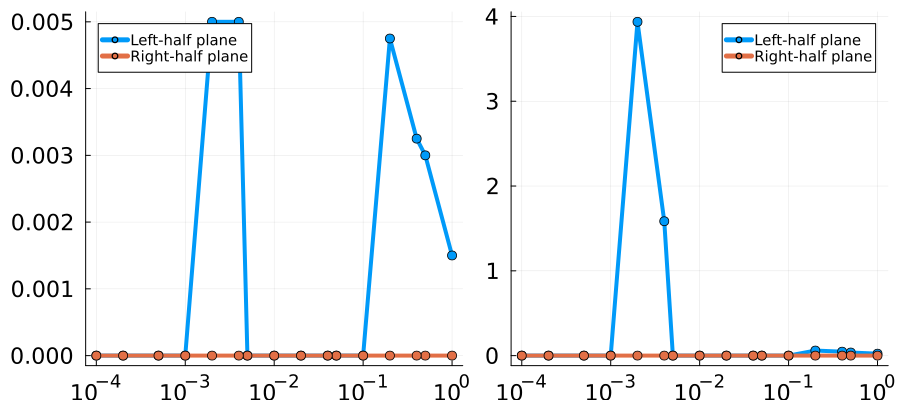

In [15]:
p_m7r=Plots.plot();
p_m7r=plot!(Delta_x.*(-1),vec(r_leftm7),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7r=plot!(Delta_x.*(-1),vec(r_rightm7),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=Plots.plot();
p_m7v=plot!(Delta_x.*(-1),vec(v_leftm7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=plot!(Delta_x.*(-1),vec(v_rightm7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m7r,p_m7v,size=(900,400))

In [16]:
t_m7=Table(Δx=Delta_x,ratio_left=vec(r_leftm7),mean_left=vec(v_leftm7),ratio_right=vec(r_rightm7),mean_right=vec(v_rightm7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0015      0.0227926  0.0          0.0
 2  │ -0.5     0.003       0.0363312  0.0          0.0
 3  │ -0.4     0.00325     0.0462889  0.0          0.0
 4  │ -0.2     0.00475     0.0595521  0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.005       1.58498    0.0          0.0
 12 │ -0.002   0.005       3.93677    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-6$, we have

In [17]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm6=zeros(1,length(Delta_x));r_rightm6=zeros(1,length(Delta_x));
v_leftm6=zeros(1,length(Delta_x));v_rightm6=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm6[j]=length(z_left)/M_s;
    r_rightm6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm6[j]=0
    end
    if length(ξ_right)==0
        v_rightm6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm6[j]=mean(μ_right)
    end
end

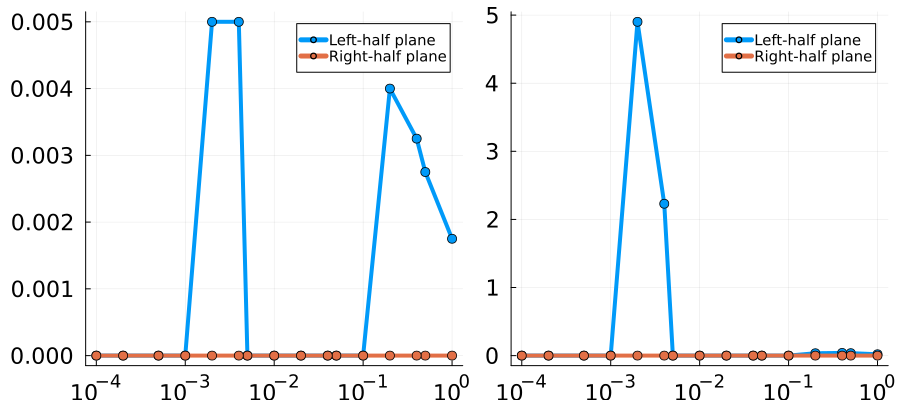

In [18]:
p_m6r=Plots.plot();
p_m6r=plot!(Delta_x.*(-1),vec(r_leftm6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6r=plot!(Delta_x.*(-1),vec(r_rightm6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=Plots.plot();
p_m6v=plot!(Delta_x.*(-1),vec(v_leftm6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=plot!(Delta_x.*(-1),vec(v_rightm6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m6r,p_m6v,size=(900,400))

In [19]:
t_m6=Table(Δx=Delta_x,ratio_left=vec(r_leftm6),mean_left=vec(v_leftm6),ratio_right=vec(r_rightm6),mean_right=vec(v_rightm6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00175     0.0197151  0.0          0.0
 2  │ -0.5     0.00275     0.0358997  0.0          0.0
 3  │ -0.4     0.00325     0.0393616  0.0          0.0
 4  │ -0.2     0.004       0.0346241  0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.005       2.22977    0.0          0.0
 12 │ -0.002   0.005       4.90128    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-5$, we have

In [20]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm5=zeros(1,length(Delta_x));r_rightm5=zeros(1,length(Delta_x));
v_leftm5=zeros(1,length(Delta_x));v_rightm5=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm5[j]=length(z_left)/M_s;
    r_rightm5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm5[j]=0
    end
    if length(ξ_right)==0
        v_rightm5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm5[j]=mean(μ_right)
    end
end

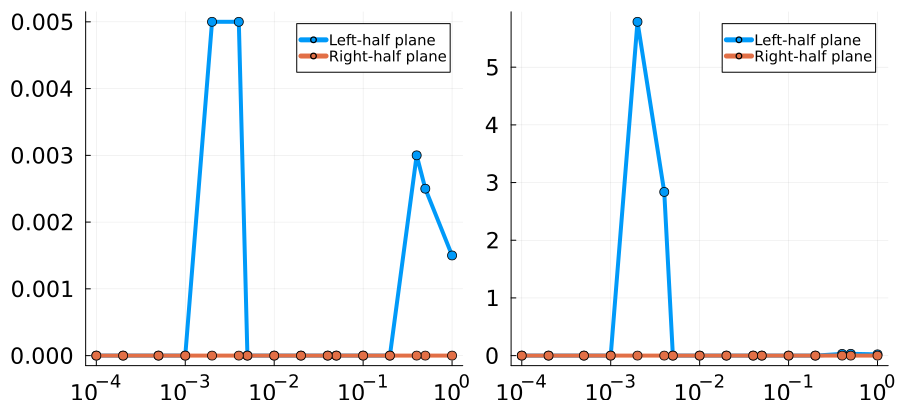

In [21]:
p_m5r=Plots.plot();
p_m5r=plot!(Delta_x.*(-1),vec(r_leftm5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5r=plot!(Delta_x.*(-1),vec(r_rightm5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=Plots.plot();
p_m5v=plot!(Delta_x.*(-1),vec(v_leftm5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=plot!(Delta_x.*(-1),vec(v_rightm5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m5r,p_m5v,size=(900,400))

In [22]:
t_m5=Table(Δx=Delta_x,ratio_left=vec(r_leftm5),mean_left=vec(v_leftm5),ratio_right=vec(r_rightm5),mean_right=vec(v_rightm5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0015      0.0218661  0.0          0.0
 2  │ -0.5     0.0025      0.0309427  0.0          0.0
 3  │ -0.4     0.003       0.029378   0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.005       2.83744    0.0          0.0
 12 │ -0.002   0.005       5.7865     0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-4$, we have

In [23]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm4=zeros(1,length(Delta_x));r_rightm4=zeros(1,length(Delta_x));
v_leftm4=zeros(1,length(Delta_x));v_rightm4=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm4[j]=length(z_left)/M_s;
    r_rightm4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm4[j]=0
    end
    if length(ξ_right)==0
        v_rightm4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm4[j]=mean(μ_right)
    end
end

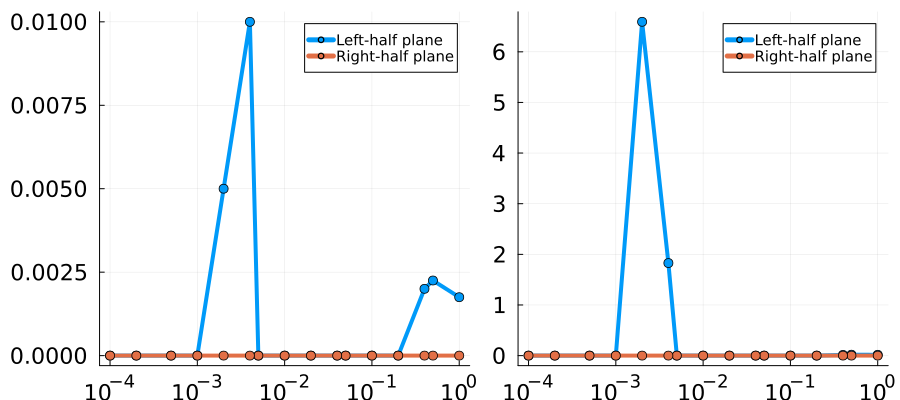

In [24]:
p_m4r=Plots.plot();
p_m4r=plot!(Delta_x.*(-1),vec(r_leftm4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4r=plot!(Delta_x.*(-1),vec(r_rightm4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=Plots.plot();
p_m4v=plot!(Delta_x.*(-1),vec(v_leftm4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=plot!(Delta_x.*(-1),vec(v_rightm4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m4r,p_m4v,size=(900,400))

In [25]:
t_m4=Table(Δx=Delta_x,ratio_left=vec(r_leftm4),mean_left=vec(v_leftm4),ratio_right=vec(r_rightm4),mean_right=vec(v_rightm4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.00175     0.0159263  0.0          0.0
 2  │ -0.5     0.00225     0.0178346  0.0          0.0
 3  │ -0.4     0.002       0.0134881  0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.01        1.82782    0.0          0.0
 12 │ -0.002   0.005       6.59206    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-3$, we have

In [26]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm3=zeros(1,length(Delta_x));r_rightm3=zeros(1,length(Delta_x));
v_leftm3=zeros(1,length(Delta_x));v_rightm3=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm3[j]=length(z_left)/M_s;
    r_rightm3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm3[j]=0
    end
    if length(ξ_right)==0
        v_rightm3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm3[j]=mean(μ_right)
    end
end

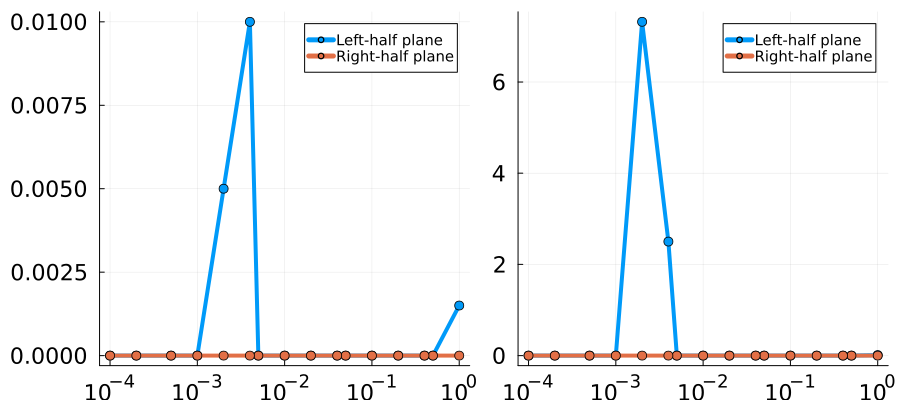

In [27]:
p_m3r=Plots.plot();
p_m3r=plot!(Delta_x.*(-1),vec(r_leftm3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3r=plot!(Delta_x.*(-1),vec(r_rightm3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=Plots.plot();
p_m3v=plot!(Delta_x.*(-1),vec(v_leftm3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=plot!(Delta_x.*(-1),vec(v_rightm3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m3r,p_m3v,size=(900,400))

In [28]:
t_m3=Table(Δx=Delta_x,ratio_left=vec(r_leftm3),mean_left=vec(v_leftm3),ratio_right=vec(r_rightm3),mean_right=vec(v_rightm3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0015      0.0108377  0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.01        2.50065    0.0          0.0
 12 │ -0.002   0.005       7.31965    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-2$, we have

In [29]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm2=zeros(1,length(Delta_x));r_rightm2=zeros(1,length(Delta_x));
v_leftm2=zeros(1,length(Delta_x));v_rightm2=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm2[j]=length(z_left)/M_s;
    r_rightm2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm2[j]=0
    end
    if length(ξ_right)==0
        v_rightm2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm2[j]=mean(μ_right)
    end
end

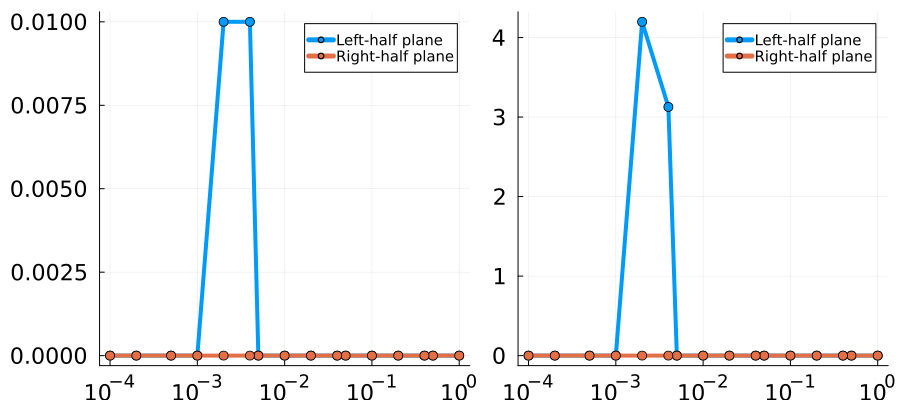

In [30]:
p_m2r=Plots.plot();
p_m2r=plot!(Delta_x.*(-1),vec(r_leftm2),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2r=plot!(Delta_x.*(-1),vec(r_rightm2),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=Plots.plot();
p_m2v=plot!(Delta_x.*(-1),vec(v_leftm2),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=plot!(Delta_x.*(-1),vec(v_rightm2),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m2r,p_m2v,size=(900,400))

In [31]:
t_m2=Table(Δx=Delta_x,ratio_left=vec(r_leftm2),mean_left=vec(v_leftm2),ratio_right=vec(r_rightm2),mean_right=vec(v_rightm2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.01        3.12717    0.0          0.0
 12 │ -0.002   0.01        4.19782    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-1$, we have

In [32]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm1=zeros(1,length(Delta_x));r_rightm1=zeros(1,length(Delta_x));
v_leftm1=zeros(1,length(Delta_x));v_rightm1=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm1[j]=length(z_left)/M_s;
    r_rightm1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm1[j]=0
    end
    if length(ξ_right)==0
        v_rightm1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm1[j]=mean(μ_right)
    end
end

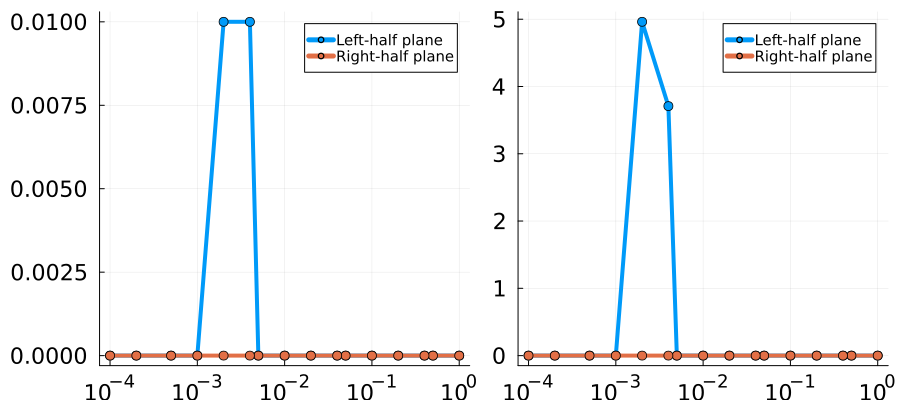

In [33]:
p_m1r=Plots.plot();
p_m1r=plot!(Delta_x.*(-1),vec(r_leftm1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1r=plot!(Delta_x.*(-1),vec(r_rightm1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=Plots.plot();
p_m1v=plot!(Delta_x.*(-1),vec(v_leftm1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=plot!(Delta_x.*(-1),vec(v_rightm1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m1r,p_m1v,size=(900,400))

In [34]:
t_m1=Table(Δx=Delta_x,ratio_left=vec(r_leftm1),mean_left=vec(v_leftm1),ratio_right=vec(r_rightm1),mean_right=vec(v_rightm1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.01        3.70843    0.0          0.0
 12 │ -0.002   0.01        4.96109    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=0$, we have

In [35]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left0=zeros(1,length(Delta_x));r_right0=zeros(1,length(Delta_x));
v_left0=zeros(1,length(Delta_x));v_right0=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A-0*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left0[j]=length(z_left)/M_s;
    r_right0[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left0[j]=0
    end
    if length(ξ_right)==0
        v_right0[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left0[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right0[j]=mean(μ_right)
    end
end

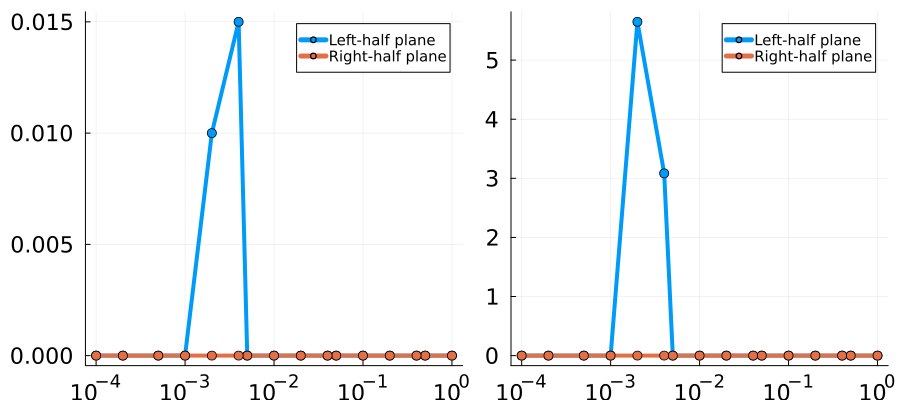

In [36]:
p_0r=Plots.plot();
p_0r=plot!(Delta_x.*(-1),vec(r_left0),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0r=plot!(Delta_x.*(-1),vec(r_right0),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=Plots.plot();
p_0v=plot!(Delta_x.*(-1),vec(v_left0),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=plot!(Delta_x.*(-1),vec(v_right0),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_0r,p_0v,size=(900,400))

In [37]:
t_0=Table(Δx=Delta_x,ratio_left=vec(r_left0),mean_left=vec(v_left0),ratio_right=vec(r_right0),mean_right=vec(v_right0))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.015       3.08364    0.0          0.0
 12 │ -0.002   0.01        5.64787    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=1$, we have

In [38]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left1=zeros(1,length(Delta_x));r_right1=zeros(1,length(Delta_x));
v_left1=zeros(1,length(Delta_x));v_right1=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left1[j]=length(z_left)/M_s;
    r_right1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left1[j]=0
    end
    if length(ξ_right)==0
        v_right1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right1[j]=mean(μ_right)
    end
end

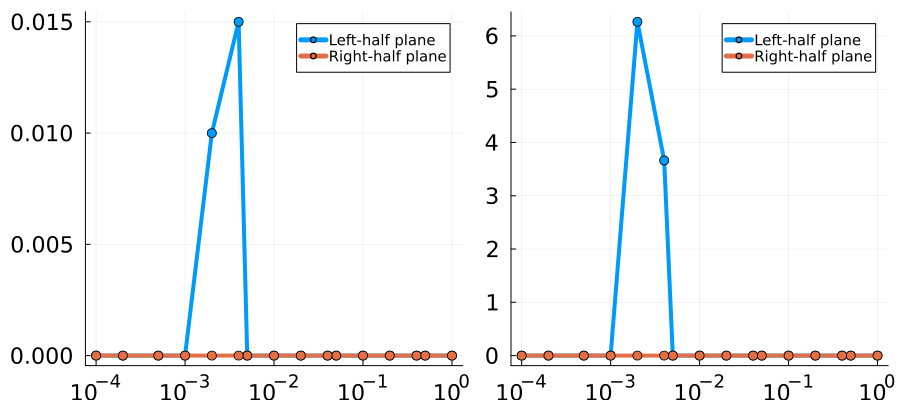

In [39]:
p_1r=Plots.plot();
p_1r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=Plots.plot();
p_1v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_1r,p_1v,size=(900,400))

In [40]:
t_1=Table(Δx=Delta_x,ratio_left=vec(r_left1),mean_left=vec(v_left1),ratio_right=vec(r_right1),mean_right=vec(v_right1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.015       3.66109    0.0          0.0
 12 │ -0.002   0.01        6.26365    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=2$, we have

In [41]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left2=zeros(1,length(Delta_x));r_right2=zeros(1,length(Delta_x));
v_left2=zeros(1,length(Delta_x));v_right2=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left2[j]=length(z_left)/M_s;
    r_right2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left2[j]=0
    end
    if length(ξ_right)==0
        v_right2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right2[j]=mean(μ_right)
    end
end

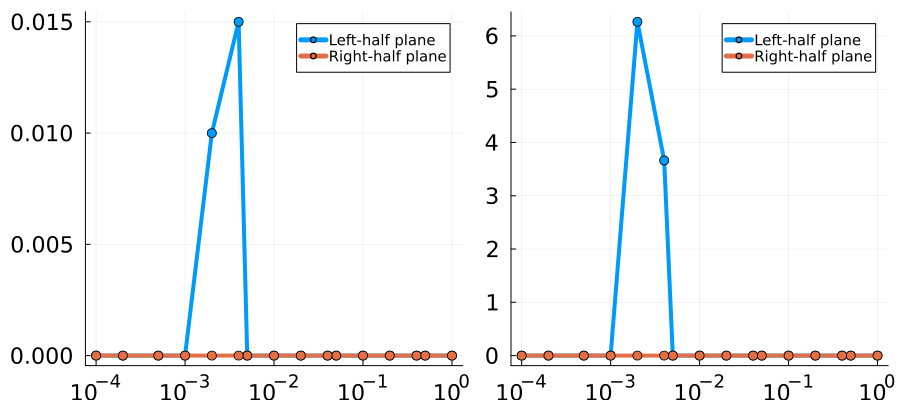

In [42]:
p_2r=Plots.plot();
p_2r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=Plots.plot();
p_2v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_2r,p_2v,size=(900,400))

In [43]:
t_2=Table(Δx=Delta_x,ratio_left=vec(r_left2),mean_left=vec(v_left2),ratio_right=vec(r_right2),mean_right=vec(v_right2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.015       4.19772    0.0          0.0
 12 │ -0.002   0.01        6.81411    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=3$, we have

In [44]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left3=zeros(1,length(Delta_x));r_right3=zeros(1,length(Delta_x));
v_left3=zeros(1,length(Delta_x));v_right3=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left3[j]=length(z_left)/M_s;
    r_right3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left3[j]=0
    end
    if length(ξ_right)==0
        v_right3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right3[j]=mean(μ_right)
    end
end

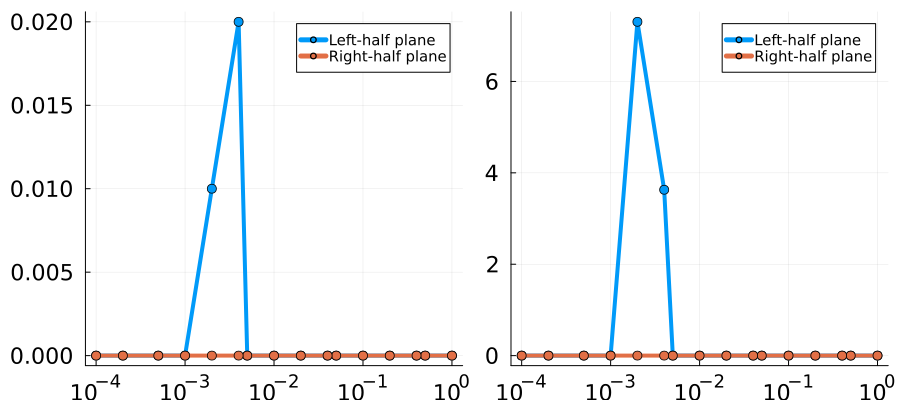

In [45]:
p_3r=Plots.plot();
p_3r=plot!(Delta_x.*(-1),vec(r_left3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3r=plot!(Delta_x.*(-1),vec(r_right3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=Plots.plot();
p_3v=plot!(Delta_x.*(-1),vec(v_left3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=plot!(Delta_x.*(-1),vec(v_right3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_3r,p_3v,size=(900,400))

In [46]:
t_3=Table(Δx=Delta_x,ratio_left=vec(r_left3),mean_left=vec(v_left3),ratio_right=vec(r_right3),mean_right=vec(v_right3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.0         0.0        0.0          0.0
 11 │ -0.004   0.02        3.62955    0.0          0.0
 12 │ -0.002   0.01        7.30496    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=4$, we have

In [47]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left4=zeros(1,length(Delta_x));r_right4=zeros(1,length(Delta_x));
v_left4=zeros(1,length(Delta_x));v_right4=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left4[j]=length(z_left)/M_s;
    r_right4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left4[j]=0
    end
    if length(ξ_right)==0
        v_right4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right4[j]=mean(μ_right)
    end
end

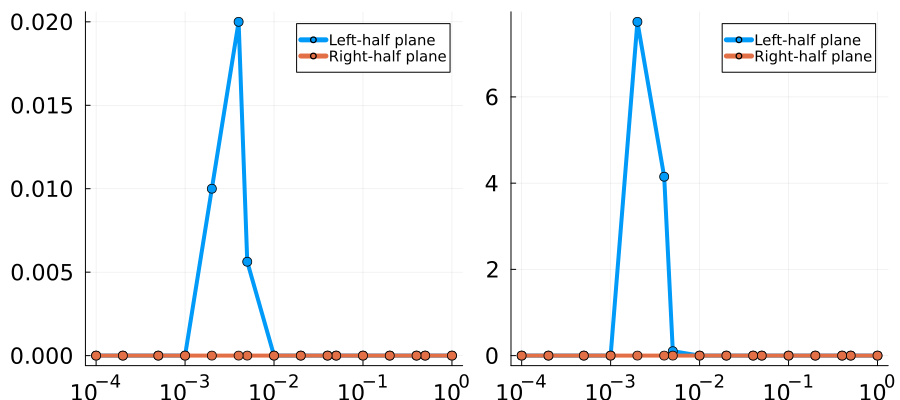

In [48]:
p_4r=Plots.plot();
p_4r=plot!(Delta_x.*(-1),vec(r_left4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4r=plot!(Delta_x.*(-1),vec(r_right4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=Plots.plot();
p_4v=plot!(Delta_x.*(-1),vec(v_left4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=plot!(Delta_x.*(-1),vec(v_right4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_4r,p_4v,size=(900,400))

In [49]:
t_4=Table(Δx=Delta_x,ratio_left=vec(r_left4),mean_left=vec(v_left4),ratio_right=vec(r_right4),mean_right=vec(v_right4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.005625    0.10254    0.0          0.0
 11 │ -0.004   0.02        4.14928    0.0          0.0
 12 │ -0.002   0.01        7.74183    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=5$, we have

In [50]:
p_5=Plots.plot();
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left5=zeros(1,length(Delta_x));r_right5=zeros(1,length(Delta_x));
v_left5=zeros(1,length(Delta_x));v_right5=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left5[j]=length(z_left)/M_s;
    r_right5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left5[j]=0
    end
    if length(ξ_right)==0
        v_right5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right5[j]=mean(μ_right)
    end
end

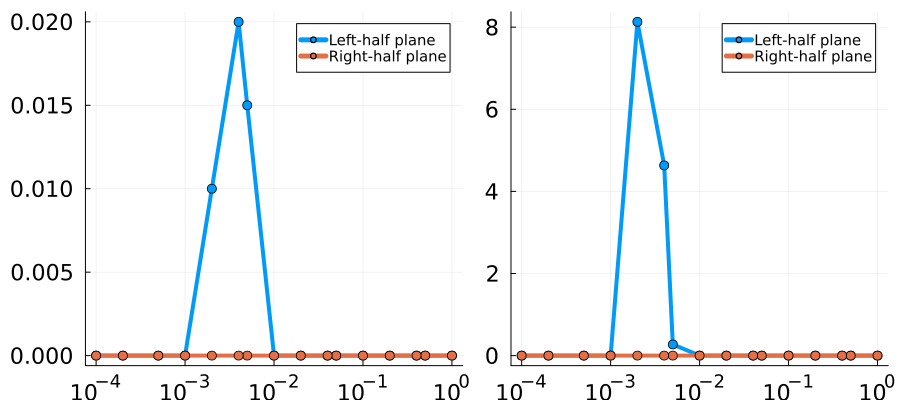

In [51]:
p_5r=Plots.plot();
p_5r=plot!(Delta_x.*(-1),vec(r_left5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5r=plot!(Delta_x.*(-1),vec(r_right5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=Plots.plot();
p_5v=plot!(Delta_x.*(-1),vec(v_left5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=plot!(Delta_x.*(-1),vec(v_right5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_5r,p_5v,size=(900,400))

In [52]:
t_5=Table(Δx=Delta_x,ratio_left=vec(r_left5),mean_left=vec(v_left5),ratio_right=vec(r_right5),mean_right=vec(v_right5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.015       0.272012   0.0          0.0
 11 │ -0.004   0.02        4.6328     0.0          0.0
 12 │ -0.002   0.01        8.13011    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=6$, we have

In [53]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left6=zeros(1,length(Delta_x));r_right6=zeros(1,length(Delta_x));
v_left6=zeros(1,length(Delta_x));v_right6=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left6[j]=length(z_left)/M_s;
    r_right6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left6[j]=0
    end
    if length(ξ_right)==0
        v_right6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right6[j]=mean(μ_right)
    end
end

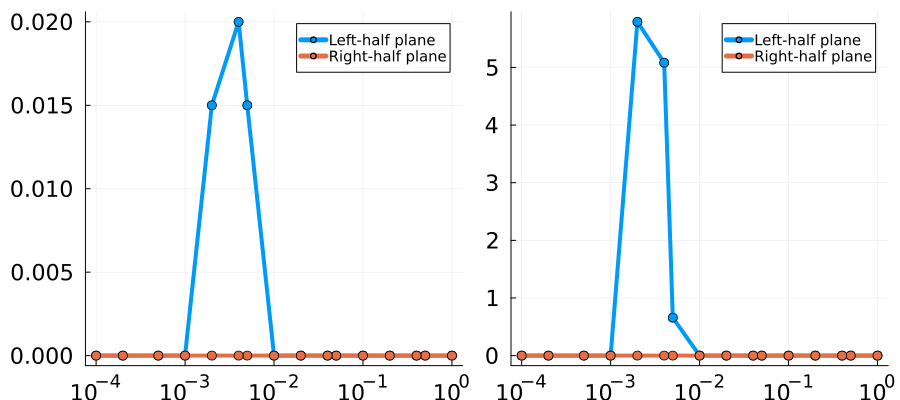

In [54]:
p_6r=Plots.plot();
p_6r=plot!(Delta_x.*(-1),vec(r_left6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6r=plot!(Delta_x.*(-1),vec(r_right6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=Plots.plot();
p_6v=plot!(Delta_x.*(-1),vec(v_left6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=plot!(Delta_x.*(-1),vec(v_right6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_6r,p_6v,size=(900,400))

In [55]:
t_6=Table(Δx=Delta_x,ratio_left=vec(r_left6),mean_left=vec(v_left6),ratio_right=vec(r_right6),mean_right=vec(v_right6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.0         0.0        0.0          0.0
 6  │ -0.05    0.0         0.0        0.0          0.0
 7  │ -0.04    0.0         0.0        0.0          0.0
 8  │ -0.02    0.0         0.0        0.0          0.0
 9  │ -0.01    0.0         0.0        0.0          0.0
 10 │ -0.005   0.015       0.657248   0.0          0.0
 11 │ -0.004   0.02        5.08209    0.0          0.0
 12 │ -0.002   0.015       5.79151    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=7$, we have

In [56]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left7=zeros(1,length(Delta_x));r_right7=zeros(1,length(Delta_x));
v_left7=zeros(1,length(Delta_x));v_right7=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left7[j]=length(z_left)/M_s;
    r_right7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left7[j]=0
    end
    if length(ξ_right)==0
        v_right7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right7[j]=mean(μ_right)
    end
end

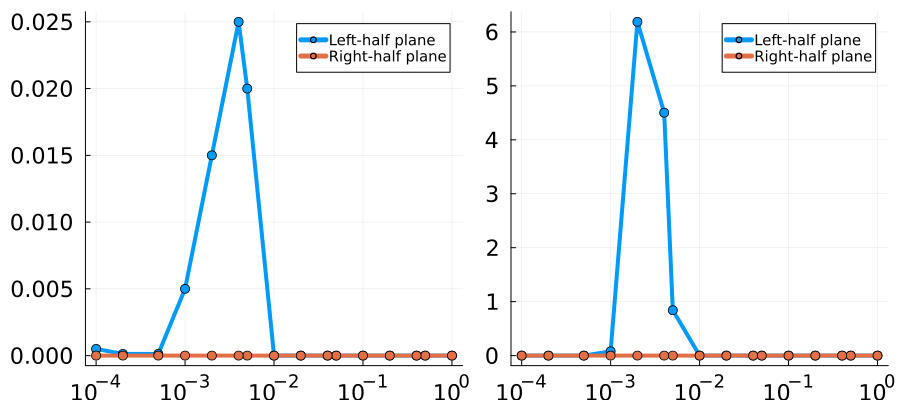

In [57]:
p_7r=Plots.plot();
p_7r=plot!(Delta_x.*(-1),vec(r_left7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7r=plot!(Delta_x.*(-1),vec(r_right7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=Plots.plot();
p_7v=plot!(Delta_x.*(-1),vec(v_left7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=plot!(Delta_x.*(-1),vec(v_right7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_7r,p_7v,size=(900,400))

In [58]:
t_7=Table(Δx=Delta_x,ratio_left=vec(r_left7),mean_left=vec(v_left7),ratio_right=vec(r_right7),mean_right=vec(v_right7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌──────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.0          0.0
 2  │ -0.5     0.0         0.0          0.0          0.0
 3  │ -0.4     0.0         0.0          0.0          0.0
 4  │ -0.2     0.0         0.0          0.0          0.0
 5  │ -0.1     0.0         0.0          0.0          0.0
 6  │ -0.05    0.0         0.0          0.0          0.0
 7  │ -0.04    0.0         0.0          0.0          0.0
 8  │ -0.02    0.0         0.0          0.0          0.0
 9  │ -0.01    0.0         0.0          0.0          0.0
 10 │ -0.005   0.02        0.84191      0.0          0.0
 11 │ -0.004   0.025       4.50303      0.0          0.0
 12 │ -0.002   0.015       6.18758      0.0          0.0
 13 │ -0.001   0.005       0.0792006    0.0          0.0
 14 │ -0.0005  0.000125    1.33227e-12  0.0          0.0
 15 │ -0.0002  0.000125    1.11022e-12  

For $x=8$, we have

In [59]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left8=zeros(1,length(Delta_x));r_right8=zeros(1,length(Delta_x));
v_left8=zeros(1,length(Delta_x));v_right8=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left8[j]=length(z_left)/M_s;
    r_right8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left8[j]=0
    end
    if length(ξ_right)==0
        v_right8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right8[j]=mean(μ_right)
    end
end

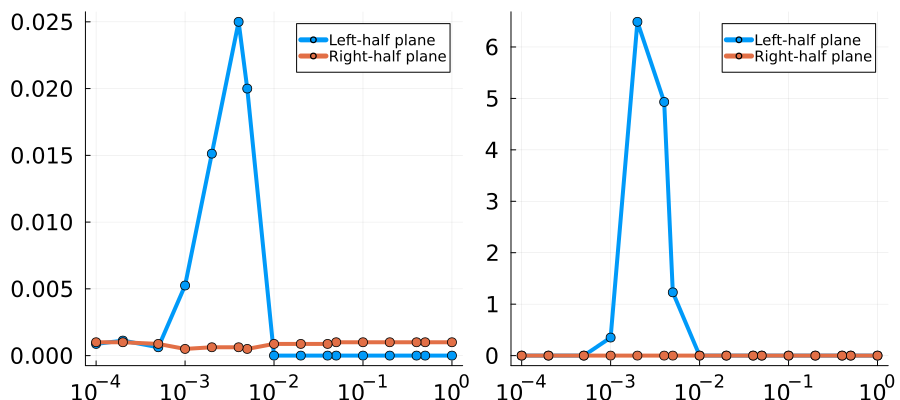

In [60]:
p_8r=Plots.plot();
p_8r=plot!(Delta_x.*(-1),vec(r_left8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8r=plot!(Delta_x.*(-1),vec(r_right8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=Plots.plot();
p_8v=plot!(Delta_x.*(-1),vec(v_left8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=plot!(Delta_x.*(-1),vec(v_right8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_8r,p_8v,size=(900,400))

In [61]:
t_8=Table(Δx=Delta_x,ratio_left=vec(r_left8),mean_left=vec(v_left8),ratio_right=vec(r_right8),mean_right=vec(v_right8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001        5.67019e-13
 2  │ -0.5     0.0         0.0          0.001        5.67379e-13
 3  │ -0.4     0.0         0.0          0.001        5.6663e-13
 4  │ -0.2     0.0         0.0          0.001        5.65797e-13
 5  │ -0.1     0.0         0.0          0.001        5.701e-13
 6  │ -0.05    0.0         0.0          0.001        5.62328e-13
 7  │ -0.04    0.0         0.0          0.000875     6.69306e-13
 8  │ -0.02    0.0         0.0          0.000875     6.62962e-13
 9  │ -0.01    0.0         0.0          0.000875     6.66134e-13
 10 │ -0.005   0.02        1.22989      0.0005       1.02141e-12
 11 │ -0.004   0.025       4.93152      0.000625     1.05471e-12
 12 │ -0.002   0.015125    6.48899      0.000625     9.10383e-13
 13 │ -0.001   0.00525     0.350691     0.0005       2.05391

For $x=9$, we have

In [62]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left9=zeros(1,length(Delta_x));r_right9=zeros(1,length(Delta_x));
v_left9=zeros(1,length(Delta_x));v_right9=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left9[j]=length(z_left)/M_s;
    r_right9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left9[j]=0
    end
    if length(ξ_right)==0
        v_right9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right9[j]=mean(μ_right)
    end
end

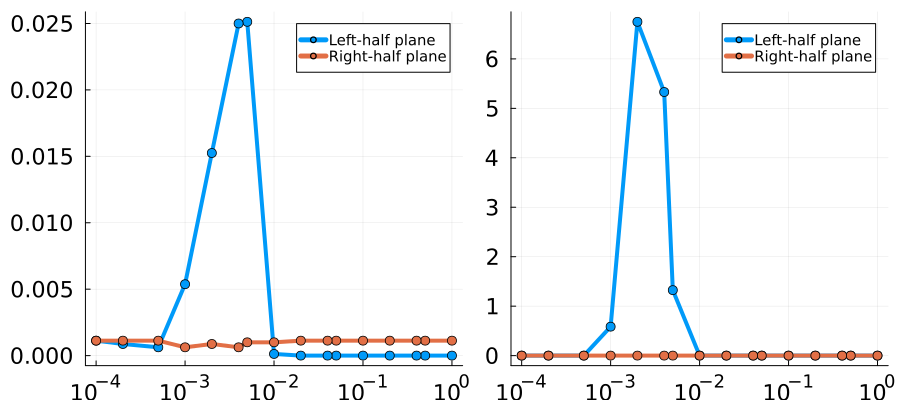

In [63]:
p_9r=Plots.plot();
p_9r=plot!(Delta_x.*(-1),vec(r_left9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9r=plot!(Delta_x.*(-1),vec(r_right9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=Plots.plot();
p_9v=plot!(Delta_x.*(-1),vec(v_left9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=plot!(Delta_x.*(-1),vec(v_right9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_9r,p_9v,size=(900,400))

In [64]:
t_9=Table(Δx=Delta_x,ratio_left=vec(r_left9),mean_left=vec(v_left9),ratio_right=vec(r_right9),mean_right=vec(v_right9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.74201e-13
 2  │ -0.5     0.0         0.0          0.001125     6.73585e-13
 3  │ -0.4     0.0         0.0          0.001125     6.73597e-13
 4  │ -0.2     0.0         0.0          0.001125     6.77606e-13
 5  │ -0.1     0.0         0.0          0.001125     6.75262e-13
 6  │ -0.05    0.0         0.0          0.001125     6.63667e-13
 7  │ -0.04    0.0         0.0          0.001125     6.89572e-13
 8  │ -0.02    0.0         0.0          0.001125     6.77236e-13
 9  │ -0.01    0.000125    1.11022e-13  0.001        7.88258e-13
 10 │ -0.005   0.025125    1.32428      0.001        7.49401e-13
 11 │ -0.004   0.025       5.32998      0.000625     8.10463e-13
 12 │ -0.002   0.01525     6.7495       0.000875     7.93016e-13
 13 │ -0.001   0.005375    0.585093     0.000625     7.10

For $x=10$, we have

In [65]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left10=zeros(1,length(Delta_x));r_right10=zeros(1,length(Delta_x));
v_left10=zeros(1,length(Delta_x));v_right10=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left10[j]=length(z_left)/M_s;
    r_right10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left10[j]=0
    end
    if length(ξ_right)==0
        v_right10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right10[j]=mean(μ_right)
    end
end

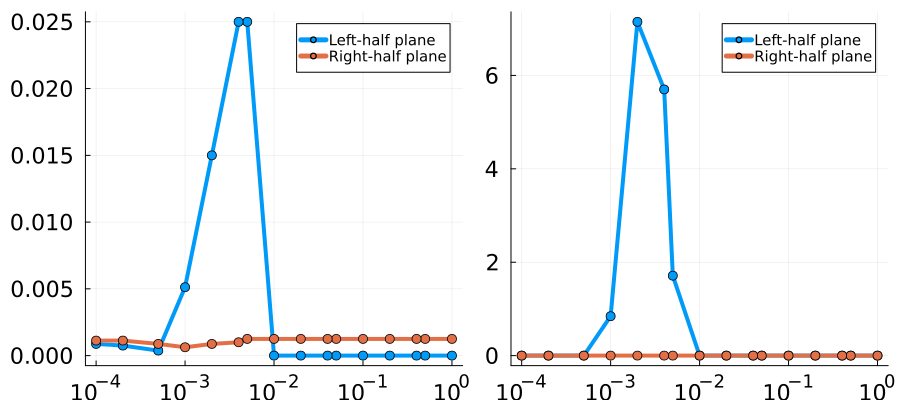

In [66]:
p_10r=Plots.plot();
p_10r=plot!(Delta_x.*(-1),vec(r_left10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10r=plot!(Delta_x.*(-1),vec(r_right10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=Plots.plot();
p_10v=plot!(Delta_x.*(-1),vec(v_left10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=plot!(Delta_x.*(-1),vec(v_right10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_10r,p_10v,size=(900,400))

In [67]:
t_10=Table(Δx=Delta_x,ratio_left=vec(r_left10),mean_left=vec(v_left10),ratio_right=vec(r_right10),mean_right=vec(v_right10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      6.95732e-13
 2  │ -0.5     0.0         0.0          0.00125      6.93934e-13
 3  │ -0.4     0.0         0.0          0.00125      6.93778e-13
 4  │ -0.2     0.0         0.0          0.00125      6.92557e-13
 5  │ -0.1     0.0         0.0          0.00125      6.99218e-13
 6  │ -0.05    0.0         0.0          0.00125      7.02549e-13
 7  │ -0.04    0.0         0.0          0.00125      6.96665e-13
 8  │ -0.02    0.0         0.0          0.00125      6.85008e-13
 9  │ -0.01    0.0         0.0          0.00125      7.34968e-13
 10 │ -0.005   0.025       1.71151      0.00125      7.23865e-13
 11 │ -0.004   0.025       5.70028      0.001        7.28584e-13
 12 │ -0.002   0.015       7.14808      0.000875     1.20538e-12
 13 │ -0.001   0.005125    0.844018     0.000625     1.77

For $x=11$, we have

In [68]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left11=zeros(1,length(Delta_x));r_right11=zeros(1,length(Delta_x));
v_left11=zeros(1,length(Delta_x));v_right11=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+11*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left11[j]=length(z_left)/M_s;
    r_right11[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left11[j]=0
    end
    if length(ξ_right)==0
        v_right11[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left11[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right11[j]=mean(μ_right)
    end
end

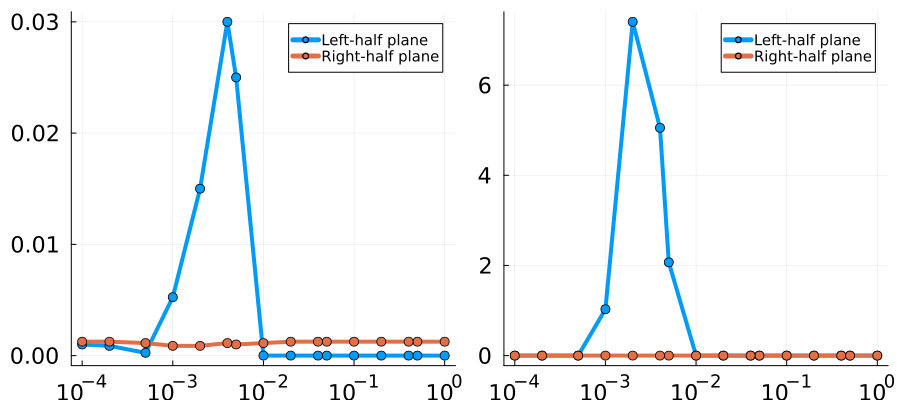

In [69]:
p_11r=Plots.plot();
p_11r=plot!(Delta_x.*(-1),vec(r_left11),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11r=plot!(Delta_x.*(-1),vec(r_right11),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=Plots.plot();
p_11v=plot!(Delta_x.*(-1),vec(v_left11),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=plot!(Delta_x.*(-1),vec(v_right11),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_11r,p_11v,size=(900,400))

In [70]:
t_11=Table(Δx=Delta_x,ratio_left=vec(r_left11),mean_left=vec(v_left11),ratio_right=vec(r_right11),mean_right=vec(v_right11))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      7.17049e-13
 2  │ -0.5     0.0         0.0          0.00125      7.17471e-13
 3  │ -0.4     0.0         0.0          0.00125      7.17537e-13
 4  │ -0.2     0.0         0.0          0.00125      7.17426e-13
 5  │ -0.1     0.0         0.0          0.00125      7.18092e-13
 6  │ -0.05    0.0         0.0          0.00125      7.22533e-13
 7  │ -0.04    0.0         0.0          0.00125      7.2331e-13
 8  │ -0.02    0.0         0.0          0.00125      7.20535e-13
 9  │ -0.01    0.0         0.0          0.001125     7.62353e-13
 10 │ -0.005   0.025       2.06976      0.001        7.43849e-13
 11 │ -0.004   0.03        5.0531       0.001125     8.38835e-13
 12 │ -0.002   0.015       7.40478      0.000875     7.13715e-13
 13 │ -0.001   0.00525     1.02842      0.000875     2.188

For $x=12$, we have

In [71]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left12=zeros(1,length(Delta_x));r_right12=zeros(1,length(Delta_x));
v_left12=zeros(1,length(Delta_x));v_right12=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+12*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left12[j]=length(z_left)/M_s;
    r_right12[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left12[j]=0
    end
    if length(ξ_right)==0
        v_right12[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left12[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right12[j]=mean(μ_right)
    end
end

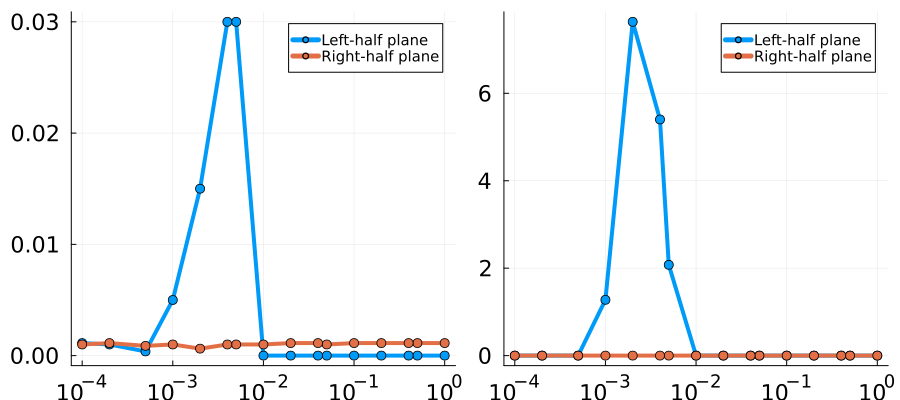

In [72]:
p_12r=Plots.plot();
p_12r=plot!(Delta_x.*(-1),vec(r_left12),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12r=plot!(Delta_x.*(-1),vec(r_right12),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=Plots.plot();
p_12v=plot!(Delta_x.*(-1),vec(v_left12),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=plot!(Delta_x.*(-1),vec(v_right12),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_12r,p_12v,size=(900,400))

In [73]:
t_12=Table(Δx=Delta_x,ratio_left=vec(r_left12),mean_left=vec(v_left12),ratio_right=vec(r_right12),mean_right=vec(v_right12))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.98281e-13
 2  │ -0.5     0.0         0.0          0.001125     6.98602e-13
 3  │ -0.4     0.0         0.0          0.001125     6.98392e-13
 4  │ -0.2     0.0         0.0          0.001125     6.98084e-13
 5  │ -0.1     0.0         0.0          0.001125     7.00181e-13
 6  │ -0.05    0.0         0.0          0.001        7.87148e-13
 7  │ -0.04    0.0         0.0          0.001125     6.9759e-13
 8  │ -0.02    0.0         0.0          0.001125     7.36448e-13
 9  │ -0.01    0.0         0.0          0.001        8.96505e-13
 10 │ -0.005   0.03        2.07634      0.001        8.65974e-13
 11 │ -0.004   0.03        5.40132      0.001        9.50628e-13
 12 │ -0.002   0.015       7.63526      0.000625     1.28786e-12
 13 │ -0.001   0.005       1.27593      0.001        2.636

For $x=13$, we have

In [74]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left13=zeros(1,length(Delta_x));r_right13=zeros(1,length(Delta_x));
v_left13=zeros(1,length(Delta_x));v_right13=zeros(1,length(Delta_x));
α = [11/6,-3,3/2,-1/3];β = [1,0,0,0];
C=A+13*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left13[j]=length(z_left)/M_s;
    r_right13[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left13[j]=0
    end
    if length(ξ_right)==0
        v_right13[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left13[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right13[j]=mean(μ_right)
    end
end

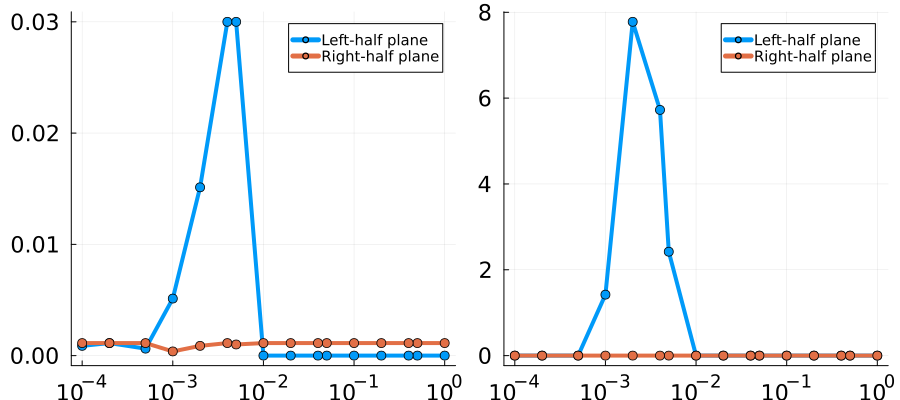

In [75]:
p_13r=Plots.plot();
p_13r=plot!(Delta_x.*(-1),vec(r_left13),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13r=plot!(Delta_x.*(-1),vec(r_right13),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=Plots.plot();
p_13v=plot!(Delta_x.*(-1),vec(v_left13),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=plot!(Delta_x.*(-1),vec(v_right13),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_13r,p_13v,size=(900,400))

In [76]:
t_13=Table(Δx=Delta_x,ratio_left=vec(r_left13),mean_left=vec(v_left13),ratio_right=vec(r_right13),mean_right=vec(v_right13))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     9.01057e-13
 2  │ -0.5     0.0         0.0          0.001125     9.01896e-13
 3  │ -0.4     0.0         0.0          0.001125     9.00514e-13
 4  │ -0.2     0.0         0.0          0.001125     9.01624e-13
 5  │ -0.1     0.0         0.0          0.001125     9.03968e-13
 6  │ -0.05    0.0         0.0          0.001125     8.99527e-13
 7  │ -0.04    0.0         0.0          0.001125     9.11e-13
 8  │ -0.02    0.0         0.0          0.001125     9.26419e-13
 9  │ -0.01    0.0         0.0          0.001125     9.27653e-13
 10 │ -0.005   0.03        2.42098      0.001        8.60423e-13
 11 │ -0.004   0.03        5.72502      0.001125     7.89492e-13
 12 │ -0.002   0.015125    7.77756      0.000875     1.12608e-12
 13 │ -0.001   0.005125    1.42026      0.000375     6.66134

To determine the overall influence of the problematic eigenvalues, we combine the above results.

In [77]:
p_c=Plots.plot();
r_left=((r_leftm10+r_leftm9+r_leftm8+r_leftm7+r_leftm6+r_leftm5+r_leftm4+r_leftm3+r_leftm2+r_leftm1+r_left0+r_left1+r_left2
        +r_left3+r_left4+r_left5+r_left6+r_left7+r_left8+r_left9+r_left10+r_left11+r_left12+r_left13)*M_s) ./ (M_s*24);
r_right=((r_rightm10+r_rightm9+r_rightm8+r_rightm7+r_rightm6+r_rightm5+r_rightm4+r_rightm3+r_rightm2+r_rightm1+r_right0+r_right1
        +r_right2+r_right3+r_right4+r_right5+r_right6+r_right7+r_right8+r_right9+r_right10+r_right11
        +r_right12+r_right13)*M_s) ./ (M_s*24);
v_left=(v_leftm10+v_leftm9+v_leftm8+v_leftm7+v_leftm6+v_leftm5+v_leftm4+v_leftm3+v_leftm2+v_leftm1+v_left0+v_left1+v_left2
        +v_left3+v_left4+v_left5+v_left6+v_left7+v_left8+v_left9+v_left10+v_left11+v_left12+v_left13) ./ 24;
v_right=(v_rightm10+v_rightm9+v_rightm8+v_rightm7+v_rightm6+v_rightm5+v_rightm4+v_rightm3+v_rightm2+v_rightm1+v_right0+v_right1
        +v_right2+v_right3+v_right4+v_right5+v_right6+v_right7+v_right8+v_right9+v_right10+v_right11+v_right12+v_right13) ./ 24;
for i=1:length(r_left)
    if r_left[i]==0
        r_left[i]=10^(-16)
    end
    if r_right[i]==0
        r_right[i]=10^(-16)
    end
    if v_left[i]==0
        v_left[i]=10^(-16)
    end
    if v_right[i]==0
        v_right[i]=10^(-16)
    end
end

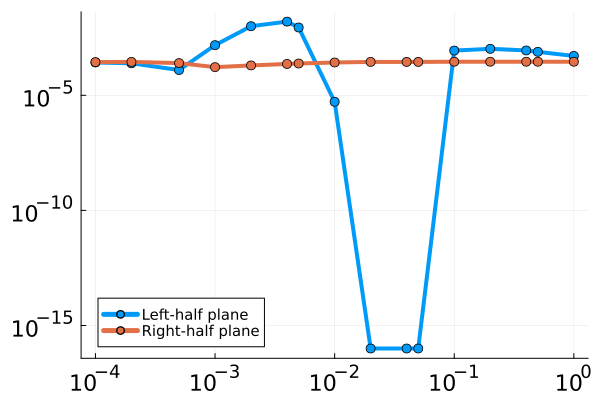

In [86]:
p_r=Plots.plot();
p_r=plot!(Delta_x.*(-1),vec(r_left),lw=4,label="Left-half plane",legend=:bottomleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_r=plot!(Delta_x.*(-1),vec(r_right),lw=4,label="Right-half plane",legend=:bottomleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

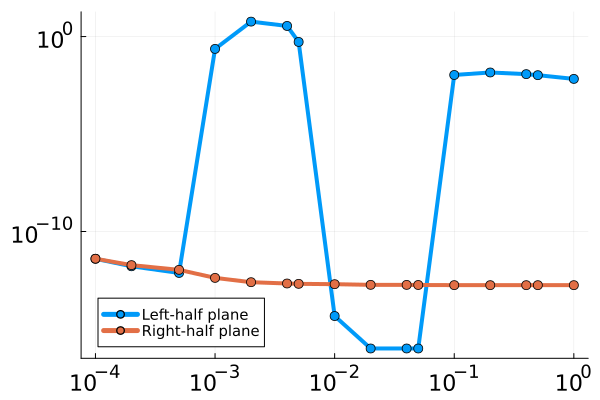

In [89]:
p_v=Plots.plot();
p_v=plot!(Delta_x.*(-1),vec(v_left),lw=4,label="Left-half plane",legend=:bottomleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_v=plot!(Delta_x.*(-1),vec(v_right),lw=4,label="Right-half plane",legend=:bottomleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

In [101]:
β=2;
TW2=TracyWidom;
xx=-2;
Delta_x=[-1,-0.5,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
err=zeros(1,length(Delta_x));
for i=1:length(Delta_x)
    dx=Delta_x[i];
    result_cdf=TW(β;method="spectral",step="bdf3",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind3=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind3]-cdf(TW2,xx;beta=2,num_points=300));
end
for j=1:length(err)
    if err[j]>1
        err[j]=1
    end
end

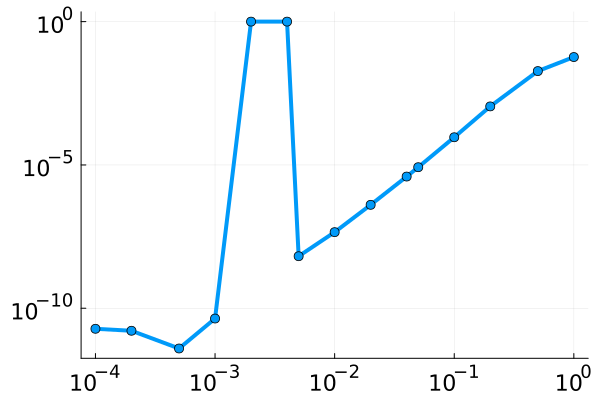

In [103]:
p_e=Plots.plot();
p_e=plot!(Delta_x.*(-1),vec(err),lw=4,legend=false,marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
    xaxis=:log,yaxis=:log)

The gap is about $[-0.004,-0.002]$ for BDF3.